### Example 3a Backward

In [1]:
Example  = '3a'
euler = 'Backward'
model = 'Model 1'
error = 'L2'

In [2]:
import copy
import gmsh
import meshio
import random
import warnings
import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
# Global constants
r = 0.27
K = 1200
beta = 0.5
k = 0.25

In [4]:
def equilibrium_point():
    u_ = K*(r - beta + k) /r
    v_ = K*(r - beta + k)*(beta - k)/ (r *k)
    return np.array([u_, v_])

In [5]:
u_ = 950
v_ = 50

print('u*: ', u_)
print('v*: ', v_)

u*:  950
v*:  50


In [6]:
ao = 0.1
bo = 2
co = 0.02
m = 0

up = 95
vp = 5

au = -1
bu = 1

av = -1
bv = 1


In [7]:
# Semi global constants
L = 200
W = L
mesh_resolution = 0.05

In [8]:
points = np.array([[L/2, W/2]])

In [9]:
def quadrature(quadorder):
    # GaussPoints to be done the numerical integration on 2D
    # Input: order
    # Output: gausspoints and gaussweights
    if quadorder == 1:
        quadpoint = np.array([[0.3333333333333, 0.3333333333333]])
        quadweight = 1/2*np.array([1.0])
    elif quadorder == 3:
        quadpoint = np.array([[0.1666666666667, 0.1666666666667],
                              [0.6666666666667, 0.1666666666667],
                              [0.1666666666667, 0.6666666666667]])
        quadweight = 1/2*np.array([0.3333333333333, 0.3333333333333, 0.3333333333333])
        
    elif quadorder == 7:
        quadpoint = np.array([[0.1012865073235, 0.1012865073235],
                              [0.7974269853531, 0.1012865073235],
                              [0.1012865073235, 0.7974269853531],
                              [0.4701420641051, 0.0597158717898],
                              [0.4701420641051, 0.4701420641051],
                              [0.0597158717898, 0.4701420641051],
                              [0.3333333333333, 0.3333333333333]])
        quadweight = 1/2*np.array([0.1259391805448, 0.1259391805448, 0.1259391805448,
                               0.1323941527885, 0.1323941527885, 0.1323941527885, 0.2250000000000])
    return quadpoint, quadweight

In [10]:
def getLagrangeBasis(typeparam,coord):

    # returns the lagrange interpolant basis and its gradients w.r.t the
    # parent coordinate system.
    #
    # [N(xi),dNdxi(xi)]=lagrange_basis(type-order,coord,dim)

    if (typeparam == 'T3'):
        ################ T3 THREE NODE TRIANGULAR ELEMENT ##################
        #
        #               3
        #             /  \
        #            /    \
        #           /      \
        #          /        \
        #         /          \
        #        /            \
        #       /              \
        #      /                \
        #     /                  \
        #    1--------------------2
        #
        if (len(coord) < 2):
            print("Error two coordinates needed for the T3 element")
        else:
            xi = coord[0] 
            eta = coord[1]
            N = np.array([1-xi-eta, xi, eta]).reshape((3,1))
            dNdxi = np.array([[-1, -1], 
                              [1, 0],
                              [0, 1]]).reshape((3,2))
        
    else:
        print("Element type not yet supported")
        N = np.array([]) 
        dNdxi = np.array([])
    
    return N, dNdxi

In [11]:
def is_between_points(point, A, B):
    return (B[0] - A[0]) * (point[1] - A[1]) == (point[0] - A[0]) * (B[1] - A[1]) and \
           min(A[0], B[0]) <= point[0] <= max(A[0], B[0]) and \
           min(A[1], B[1]) <= point[1] <= max(A[1], B[1])

def is_point_in_triangle(point, A, B, C):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(point, A, B)
    d2 = sign(point, B, C)
    d3 = sign(point, C, A)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

In [12]:
def generate_mesh(L, W, mesh_resolution, points):
    # Initialize Gmsh
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)

    # Create the terminal points
    p1 = gmsh.model.geo.addPoint(0, 0, 0, meshSize=mesh_resolution*L)
    p2 = gmsh.model.geo.addPoint(L, 0, 0, meshSize=mesh_resolution*L)
    p3 = gmsh.model.geo.addPoint(L, W, 0, meshSize=mesh_resolution*L)
    p4 = gmsh.model.geo.addPoint(0, W, 0, meshSize=mesh_resolution*L)

    # Create the lines
    l1 = gmsh.model.geo.addLine(p1, p2)
    l2 = gmsh.model.geo.addLine(p2, p3)
    l3 = gmsh.model.geo.addLine(p3, p4)
    l4 = gmsh.model.geo.addLine(p4, p1)

    # Create the loop
    loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

    # Create the surface
    surface = gmsh.model.geo.addPlaneSurface([loop])
    
    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), mesh_resolution)

    # Generate mesh
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)

    # Write the mesh data to a file
    gmsh.write("mesh.msh")

    mesh = meshio.read("mesh.msh")
    nodes = mesh.points
    elements = mesh.cells_dict["triangle"]

    gmsh.finalize()
    nodes = nodes[:, :-1]
    if(points.shape[1] == 0):
        return nodes, elements
    
    for point in points:
        numnode = nodes.shape[0]
        numelem = elements.shape[0]

        flag = False
        index = np.where((nodes == point).all(axis=1))[0]

        if(len(index)>0):
            point_index = index[0]
            flag = True
        else:
            nodes = np.append(nodes, np.array([point]), axis=0)
            point_index = numnode
            numnode +=1

        if(not flag):
            for iel in range(numelem):
                econ = elements[iel, :]

                for j in range(econ.shape[0]):
                    point_A = nodes[econ[j]]
                    point_B = nodes[econ[(j+1)%(econ.shape[0])]]

                    if(is_between_points(point, point_A, point_B)):
                        flag = True

                        new_econ_1 = copy.deepcopy(econ)
                        new_econ_2 = copy.deepcopy(econ)

                        new_econ_1[j] = point_index
                        new_econ_2[(j+1)%(econ.shape[0])] = point_index

                        elements[iel, :] = new_econ_1
                        elements = np.append(elements, np.array([new_econ_2]), axis=0)
                        break

        if(not flag):
            for iel in range(numelem):
                econ = elements[iel, :]

                point_A = nodes[econ[0]] 
                point_B = nodes[econ[1]]
                point_C = nodes[econ[2]]

                if(is_point_in_triangle(point, point_A, point_B, point_C)):
                    flag = True

                    new_econ_1 = copy.deepcopy(econ)
                    new_econ_2 = copy.deepcopy(econ)
                    new_econ_3 = copy.deepcopy(econ)

                    new_econ_1[0] = point_index
                    new_econ_2[1] = point_index
                    new_econ_3[2] = point_index

                    elements[iel, :] = new_econ_1
                    elements = np.append(elements, np.array([new_econ_2]), axis=0)
                    elements = np.append(elements, np.array([new_econ_3]), axis=0)
                    break

        if(not flag):
            print(f'Point {point} has not been assigned to any element :(')
            raise KeyboardInterrupt('Execution stopped due to a condition.')

    return nodes, elements

def plot_region(nodes, elements):
    plt.figure(figsize=(6, 6))
    plt.triplot(nodes[:, 0], nodes[:, 1], elements)
    plt.plot(nodes[:, 0], nodes[:, 1], 'o', markersize=1, color='red')
    plt.xlabel('X', fontsize = 14)
    plt.ylabel('Y', fontsize = 14)
    plt.title('The triangulated region', fontsize = 16)
    plt.savefig('plots/mesh_nodes_{nodes.shape[0]}_elem_{elements.shape[0]}.eps', format='eps')
    # plt.show()

Info    : Increasing process stack size (8176 kB < 16 MB)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000228458s, CPU 0.000189s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00974804s, CPU 0.00748s)
Info    : 514 nodes 1030 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'

Number of nodes: 515
Number of elements: 948


/var/folders/54/ccfr7ph1425cvxjxllgbr1mw0000gn/T/ipykernel_2082/3459729414.py:6: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  elements = np.loadtxt('data/elements.csv', delimiter=',', dtype=int)


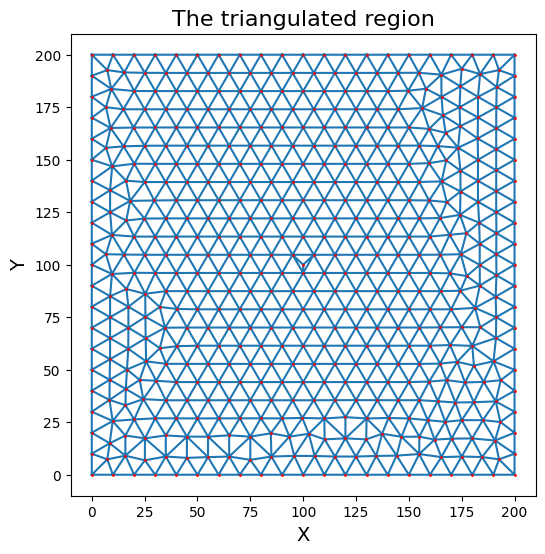

In [13]:
nodes, elements = generate_mesh(L, W, mesh_resolution, points)
np.savetxt('data/nodes.csv', nodes, delimiter=',')
np.savetxt('data/elements.csv', elements, delimiter=',')

nodes = np.loadtxt('data/nodes.csv', delimiter=',')
elements = np.loadtxt('data/elements.csv', delimiter=',', dtype=int)
plot_region(nodes, elements)
print("Number of nodes:", nodes.shape[0])
print("Number of elements:", elements.shape[0])

In [14]:
x2 = 1/(3*np.sqrt(3)) * L*W / elements.shape[0]
D = max(ao, bo, co)

dt = min(0.5 * x2 / D, 0.2)

dt = np.floor(dt*1000)/1000
print('dt: ', dt)

if(dt == 0):
    print('dt is 0 :(')
    raise KeyboardInterrupt('Execution stopped due to a condition.')

dt:  0.2


In [15]:
# Semi global constants
t0 = 0
t_infinity = 300

tolerance = 1e-5

In [16]:
def initial_condition(X, Y, u_, v_, up, vp, au, bu, av, bv):
    u0 = u_ *np.ones_like(X) + up *np.random.uniform(au, bu, np.shape(X))
    v0 = v_ *np.ones_like(Y) + vp *np.random.uniform(av, bv, np.shape(Y))

    if(Example == '1c'):
        u0 = u_ *np.ones_like(X)
        v0 = v_ *np.ones_like(Y)

        point = np.array([L/2, W/2])
        index = np.where((nodes == point).all(axis=1))[0]
        print(index)

        u0[index] += up *np.random.uniform(au, bu, 1)
        v0[index] += vp *np.random.uniform(av, bv, 1)
    
    return u0, v0

In [17]:
warnings.filterwarnings('ignore')
np.random.seed(42)

x = nodes[:,0]
y = nodes[:,1]

u0, v0 = initial_condition(x, y, u_, v_, up, vp, au, bu, av, bv)

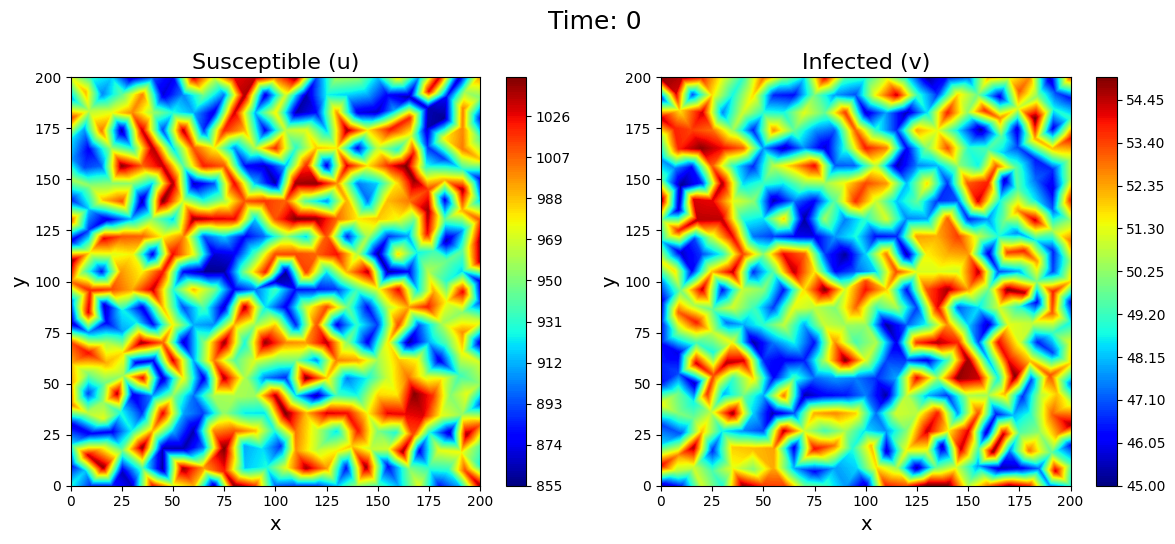

In [18]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

# Plot u0 on the first subplot (left)
contour1 = ax1.tricontourf(x, y, u0, levels=200, cmap='jet')
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14)
ax1.set_title('Susceptible (u)', fontsize=16)
fig.colorbar(contour1, ax=ax1)

# Plot v0 on the second subplot (right)
contour2 = ax2.tricontourf(x, y, v0, levels=200, cmap='jet')
ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14)
ax2.set_title('Infected (v)', fontsize=16)
fig.colorbar(contour2, ax=ax2)

fig.suptitle('Time: 0', fontsize=18)

plt.tight_layout()
plt.show()

In [19]:
def f(u, v):
    return r*u*(1 - u/K) - beta* u*v / (u+v)

def g(u, v):
    return beta* u*v / (u+v) - k*v

def a(u, m=0):
    return ao *u**m

def b(v, m=0):
    return bo *v**m

def c(u, v, model='Model 1'):
    if (model=='Model 1'):
        return co
    else:
        coefficent_c = co*u*v *(c1 - u -v)
        coefficent_zeros = np.zeros_like(coefficent_c)
        return np.maximum(coefficent_c, coefficent_zeros)


In [20]:
def bilinear_matrix(nodes, elements, model='Model 1', m=0, u0=None, v0=None):      
    # Number of nodes
    numnode = len(nodes)

    # Define the element connectivity
    numelem = len(elements)

    ndof = 1  # Degrees of freedom per node

    # Number of unknowns
    totalUnknown = numnode * ndof

    # Initialize the system matrices
    M = sp.sparse.lil_matrix((totalUnknown, totalUnknown)).toarray()
    K1 = sp.sparse.lil_matrix((totalUnknown, totalUnknown)).toarray()
    K2 = sp.sparse.lil_matrix((totalUnknown, totalUnknown)).toarray()
    K3 = sp.sparse.lil_matrix((totalUnknown, totalUnknown)).toarray()

    # Get the integration points
    numgp = 7
    q, w = quadrature(numgp)

    # Loop over elements
    for iel in range(numelem):
        
        # Get the current element connectivity
        econ = elements[iel, :]

        # Get the nodal coordinates
        nds = nodes[econ]

        # u, v at nodes
        u_nds = u0[econ]
        v_nds = v0[econ]

        # Get the global index
        gind = econ

        # Integration
        # Loop over the integration points
        for igp in range(len(w)):

            # Get the current integration point
            pt = q[igp]

            # Get the shape functions and its derivatives
            N, dNdxi = getLagrangeBasis('T3', pt)

            # Get the jacobian
            jac = dNdxi.T @ nds

            if(np.linalg.det(jac) < 0):
                print(f'Determinant of the jacobian is negative for element: {iel} :(')
                raise KeyboardInterrupt('Execution stopped due to a condition.')

            # Global gauss point
            gpt = N.T @ nds

            # u, v at gauss point
            u_gpt = N.T @ u_nds
            v_gpt = N.T @ v_nds
            
            # derivatives of shape functions in physical coordinates (global)
            dNdx = np.linalg.solve(jac, dNdxi.T)
            
            # get the coefficients
            a_gpt = a(u_gpt, m)
            b_gpt = b(v_gpt, m)
            c_gpt = c(u_gpt, v_gpt, model)

            # mass matrix
            M[np.ix_(gind, gind)] += N @ N.T * np.linalg.det(jac) * w[igp]

            # stiffness matrices
            K1[np.ix_(gind, gind)] += dNdx.T @ (a_gpt * dNdx) * np.linalg.det(jac) * w[igp]
            K2[np.ix_(gind, gind)] += dNdx.T @ (b_gpt * dNdx) * np.linalg.det(jac) * w[igp]
            K3[np.ix_(gind, gind)] += dNdx.T @ (c_gpt * dNdx) * np.linalg.det(jac) * w[igp]

    return M, K1, K2, K3

In [21]:
def linear_vector(nodes, elements, u0=None, v0=None):      
    # Number of nodes
    numnode = len(nodes)

    # Define the element connectivity
    numelem = len(elements)

    ndof = 1  # Degrees of freedom per node

    # Number of unknowns
    totalUnknown = numnode * ndof

    # Initialize the system matrices
    F0 = sp.sparse.lil_matrix((totalUnknown, 1)).toarray()
    G0 = sp.sparse.lil_matrix((totalUnknown, 1)).toarray()

    # Get the integration points
    numgp = 7
    q, w = quadrature(numgp)

    # Loop over elements
    for iel in range(numelem):
        
        # Get the current element connectivity
        econ = elements[iel, :]

        # Get the nodal coordinates
        nds = nodes[econ]

        # u, v at nodes
        u_nds = u0[econ]
        v_nds = v0[econ]

        # Get the global index
        gind = econ

        # Integration
        # Loop over the integration points
        for igp in range(len(w)):

            # Get the current integration point
            pt = q[igp]

            # Get the shape functions and its derivatives
            N, dNdxi = getLagrangeBasis('T3', pt)

            # Get the jacobian
            jac = dNdxi.T @ nds

            if(np.linalg.det(jac) < 0):
                print(f'Determinant of the jacobian is negative for element: {iel} :(')
                raise KeyboardInterrupt('Execution stopped due to a condition.')
            
            # Global gauss point
            gpt = N.T @ nds

            # u, v at gauss point
            u_gpt = N.T @ u_nds
            v_gpt = N.T @ v_nds
            
            f_gpt = f(u_gpt, v_gpt)
            g_gpt = g(u_gpt, v_gpt)
            
            # force vectors
            F0[gind] += f_gpt * N * np.linalg.det(jac) * w[igp]
            G0[gind] += g_gpt * N * np.linalg.det(jac) * w[igp] 
    
    return F0, G0

In [22]:
u_initial = u0.reshape(-1,1)
v_initial = v0.reshape(-1,1)
print(model)

M, K1, K2, K3 = bilinear_matrix(nodes, elements, model, m, u_initial, v_initial)

Model 1


### Forward Euler

\begin{align*}
    K_{1,n} u_{n} + K_{3,n} v_{n} + M \left(\frac{u_{n+1} - u_n}{\Delta t} \right) = F_{n} \\
    K_{2,n} v_{n} + M \left(\frac{v_{n+1} - v_n}{\Delta t} \right) = G_{n}
\end{align*}

\begin{align*}
\left[\begin{array}{cc}
M & 0 \\
0 & M
\end{array}\right] \left(\begin{array}{c}
u_{n+1} \\
v_{n+1}
\end{array}\right)=\left[\begin{array}{cc}
M - \Delta t K_{1,n} & -\Delta t K_{3,n} \\
0 & M - \Delta t K_{2,n}
\end{array}\right]\left(\begin{array}{c}
u_n \\
v_n
\end{array}\right)+\Delta t\left(\begin{array}{c}
F_{n} \\
G_{n}
\end{array}\right)
\end{align*}

### Backward Euler

\begin{align*}
    K_{1,n+1} u_{n+1} + K_{3,n+1} v_{n+1} + M \left(\frac{u_{n+1} - u_n}{\Delta t} \right) = F_{n+1} \\
    K_{2,n+1} v_{n+1} + M \left(\frac{v_{n+1} - v_n}{\Delta t} \right) = G_{n+1}
\end{align*}

\begin{align*}
\left[\begin{array}{cc}
M + \Delta t K_{1,n+1} & \Delta t K_{3,n+1} \\
0 & M + \Delta t K_{2,n+1}
\end{array}\right] \left(\begin{array}{c}
u_{n+1} \\
v_{n+1}
\end{array}\right)=\left[\begin{array}{cc}
M & 0 \\
0 & M
\end{array}\right]\left(\begin{array}{c}
u_n \\
v_n
\end{array}\right)+\Delta t\left(\begin{array}{c}
F_{n+1} \\
G_{n+1}
\end{array}\right)
\end{align*}

### Picard's Iteration for backward euler in transient diffusion:

\begin{align*}
(M + \Delta t K_{1,n+1}^{\theta}) \cdot u_{n+1}^{\theta+1} &= M \cdot u_n - \Delta t K_{3,n+1}^\theta \cdot v_{n+1}^\theta + \Delta t F_{n+1}^{\theta} \\
(M + \Delta t K_{2,n+1}^{\theta}) \cdot v_{n+1}^{\theta+1} &= M \cdot v_n + \Delta t \, G_{n+1}^{\theta}
\end{align*}

In [23]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

def L2error(y, y_hat):
    return np.sqrt(np.linalg.norm(y-y_hat))

In [24]:
def picards_iteration_transient_model1(nodes, elements, u_guess, v_guess, un, vn, 
                      M, K1, K2, K3, dt, tolerance, error):

    numitr = 1
    F, G = linear_vector(nodes, elements, u_guess, v_guess)

    u_val = np.maximum(np.zeros_like(u_guess), np.linalg.solve(M + dt*K1, M @ un - dt*K3 @ v_guess + dt*F))
    v_val = np.maximum(np.zeros_like(v_guess), np.linalg.solve(M + dt*K2, M @ vn + dt*G))

    if(error == 'mse'):
        u_error = mse(u_val, u_guess)
        v_error = mse(v_val, v_guess)

    if(error == 'L2'):
        u_error = L2error(u_val, u_guess)
        v_error = L2error(v_val, v_guess)

    while(max(u_error, v_error)>tolerance):
        numitr += 1

        u_guess = copy.deepcopy(u_val)
        v_guess = copy.deepcopy(v_val)

        F, G = linear_vector(nodes, elements, u_guess, v_guess)

        u_val = np.maximum(np.zeros_like(u_guess), np.linalg.solve(M + dt*K1, M @ un - dt*K3 @ v_guess + dt*F))
        v_val = np.maximum(np.zeros_like(v_guess), np.linalg.solve(M + dt*K2, M @ vn + dt*G))

        if(error == 'mse'):
            u_error = mse(u_val, u_guess)
            v_error = mse(v_val, v_guess)
        
        if(error == 'L2'):
            u_error = L2error(u_val, u_guess)
            v_error = L2error(v_val, v_guess)

    return u_val, v_val, numitr, u_error, v_error

In [25]:
def picards_iteration_transient_model2(nodes, elements, u_guess, v_guess, un, vn, 
                      m, dt, tolerance, error):

    numitr = 1
    M, K1, K2, K3 = bilinear_matrix(nodes, elements, 'Model 2', m, u_guess, v_guess)
    F, G = linear_vector(nodes, elements, u_guess, v_guess)

    u_val = np.maximum(np.zeros_like(u_guess),np.linalg.solve(M + dt*K1, M @ un - dt*K3 @ v_guess + dt*F))
    v_val = np.maximum(np.zeros_like(v_guess),np.linalg.solve(M + dt*K2, M @ vn + dt*G))

    if(error == 'mse'):
        u_error = mse(u_val, u_guess)
        v_error = mse(v_val, v_guess)

    if(error == 'L2'):
        u_error = L2error(u_val, u_guess)
        v_error = L2error(v_val, v_guess)

    while(max(u_error, v_error)>tolerance):
        numitr += 1

        u_guess = copy.deepcopy(u_val)
        v_guess = copy.deepcopy(v_val)

        M, K1, K2, K3 = bilinear_matrix(nodes, elements, 'Model 2', m, u_guess, v_guess)
        F, G = linear_vector(nodes, elements, u_guess, v_guess)

        u_val = np.maximum(np.zeros_like(u_guess), np.linalg.solve(M + dt*K1, M @ un - dt*K3 @ v_guess + dt*F))
        v_val = np.maximum(np.zeros_like(v_guess), np.linalg.solve(M + dt*K2, M @ vn + dt*G))

        if(error == 'mse'):
            u_error = mse(u_val, u_guess)
            v_error = mse(v_val, v_guess)
        
        if(error == 'L2'):
            u_error = L2error(u_val, u_guess)
            v_error = L2error(v_val, v_guess)

    return u_val, v_val, numitr, u_error, v_error

In [26]:
def newton_raphson():
    pass

In [27]:
def transient_solution_model1(nodes, u_initial, v_initial,
                       M, K1, K2, K3, t0, t_infinity, dt, euler, error):

    t = t0
    u_values = []
    v_values = []

    u_errors = []
    v_errors = []

    itr = []

    u_value = np.maximum(np.zeros_like(u_initial), copy.deepcopy(u_initial))
    v_value = np.maximum(np.zeros_like(v_initial), copy.deepcopy(v_initial))

    u_values.append(u_value)
    v_values.append(v_value)

    itr.append(0)
    u_errors.append(0)
    v_errors.append(0)

    F, G = linear_vector(nodes, elements, u_value, v_value)
    
    # Using tqdm to track the loop progress
    with tqdm(total=int((t_infinity - t0) / dt)) as pbar:
        while(t <= t_infinity):
            if(euler == 'Forward'):
                u_value = np.maximum(np.zeros_like(u_value), np.linalg.solve(M, (M - dt*K1) @ u_value - dt*K3 @ v_value + dt*F))
                v_value = np.maximum(np.zeros_like(v_value), np.linalg.solve(M, (M - dt*K2) @ v_value + dt*G))

                F, G = linear_vector(nodes, elements, u_value, v_value)  
                
                numitr = 1
                itr.append(numitr) 

                u_errors.append(0)
                v_errors.append(0) 

            if(euler == 'Backward'):
                u_guess = copy.deepcopy(u_value)
                v_guess = copy.deepcopy(v_value)

                un = copy.deepcopy(u_value)
                vn = copy.deepcopy(v_value)

                u_value, v_value, numitr, u_error, v_error = \
                    picards_iteration_transient_model1(nodes, elements, u_guess, v_guess, un, vn, 
                      M, K1, K2, K3, dt, tolerance, error)
                
                F, G = linear_vector(nodes, elements, u_value, v_value)  
                itr.append(numitr)

                u_errors.append(u_error)
                v_errors.append(v_error)

            u_values.append(u_value)
            v_values.append(v_value)
            
            t += dt
            pbar.update()

    return u_values, v_values, itr, u_errors, v_errors


In [28]:
def transient_solution_model2(nodes, u_initial, v_initial,
                       m, t0, t_infinity, dt, euler, error):

    t = t0
    u_values = []
    v_values = []

    u_errors = []
    v_errors = []

    itr = []

    u_value = np.maximum(np.zeros_like(u_initial), copy.deepcopy(u_initial))
    v_value = np.maximum(np.zeros_like(v_initial), copy.deepcopy(v_initial))

    u_values.append(u_value)
    v_values.append(v_value)

    itr.append(0)
    u_errors.append(0)
    v_errors.append(0)

    M, K1, K2, K3 = bilinear_matrix(nodes, elements, 'Model 2', m, u_value, v_value)
    F, G = linear_vector(nodes, elements, u_value, v_value)
    
    # Using tqdm to track the loop progress
    with tqdm(total=int((t_infinity - t0) / dt)) as pbar:
        while(t <= t_infinity):
            if(euler == 'Forward'):
                u_value = np.maximum(np.zeros_like(u_value), np.linalg.solve(M, (M - dt*K1) @ u_value - dt*K3 @ v_value + dt*F))
                v_value = np.maximum(np.zeros_like(v_value), np.linalg.solve(M, (M - dt*K2) @ v_value + dt*G))

                M, K1, K2, K3 = bilinear_matrix(nodes, elements, 'Model 2', m, u_value, v_value)
                F, G = linear_vector(nodes, elements, u_value, v_value)  
                
                numitr = 1
                itr.append(numitr) 

                u_errors.append(0)
                v_errors.append(0) 

            if(euler == 'Backward'):
                u_guess = copy.deepcopy(u_value)
                v_guess = copy.deepcopy(v_value)

                un = copy.deepcopy(u_value)
                vn = copy.deepcopy(v_value)

                u_value, v_value, numitr, u_error, v_error = \
                    picards_iteration_transient_model2(nodes, elements, u_guess, v_guess, 
                      un, vn, m, dt, tolerance, error)
                
                itr.append(numitr)

                u_errors.append(u_error)
                v_errors.append(v_error)

            u_values.append(u_value)
            v_values.append(v_value)
            
            t += dt
            pbar.update()

    return u_values, v_values, itr, u_errors, v_errors


In [29]:
if(model == 'Model 1'):
    u_values, v_values, itr, u_errors, v_errors = transient_solution_model1(nodes, u_initial, v_initial,
                       M, K1, K2, K3, t0, t_infinity, dt, euler, error)
else:
    u_values, v_values, itr, u_errors, v_errors = transient_solution_model2(nodes, u_initial, v_initial,
                       m, t0, t_infinity, dt, euler, error)

1501it [46:04,  1.84s/it]                          


In [30]:
np.savetxt('data/u_values.csv', np.column_stack(u_values), delimiter=',')
np.savetxt('data/v_values.csv', np.column_stack(v_values), delimiter=',')

np.savetxt('data/itr.csv', itr, delimiter=',')
np.savetxt('data/u_errors.csv', u_errors, delimiter=',')
np.savetxt('data/v_errors.csv', v_errors, delimiter=',')

In [31]:
model

'Model 1'

In [32]:
euler

'Backward'

In [33]:
TIME = np.array([0, 10, 100, 200, 300])

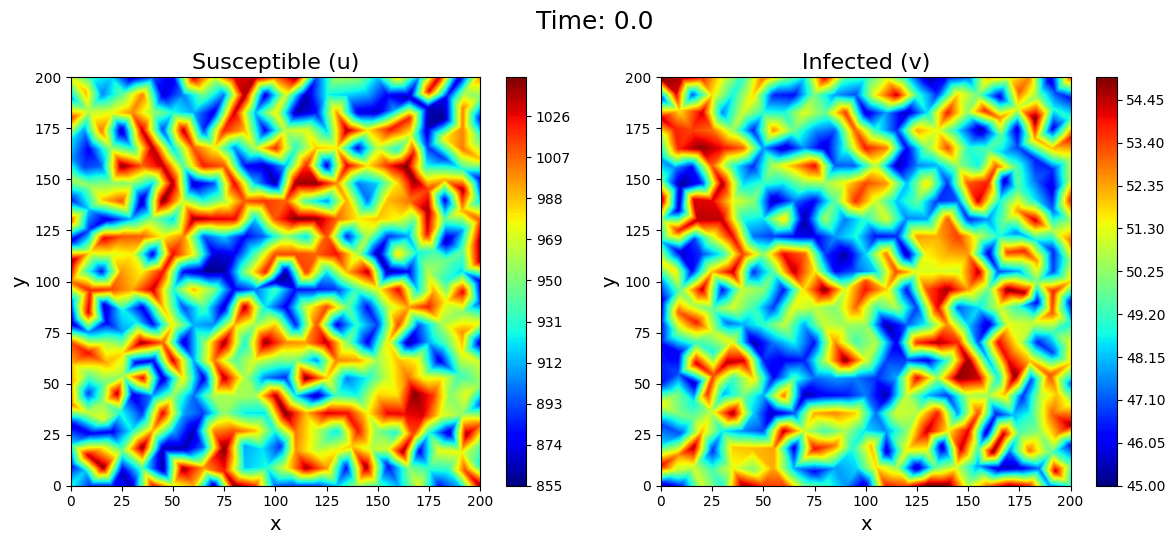

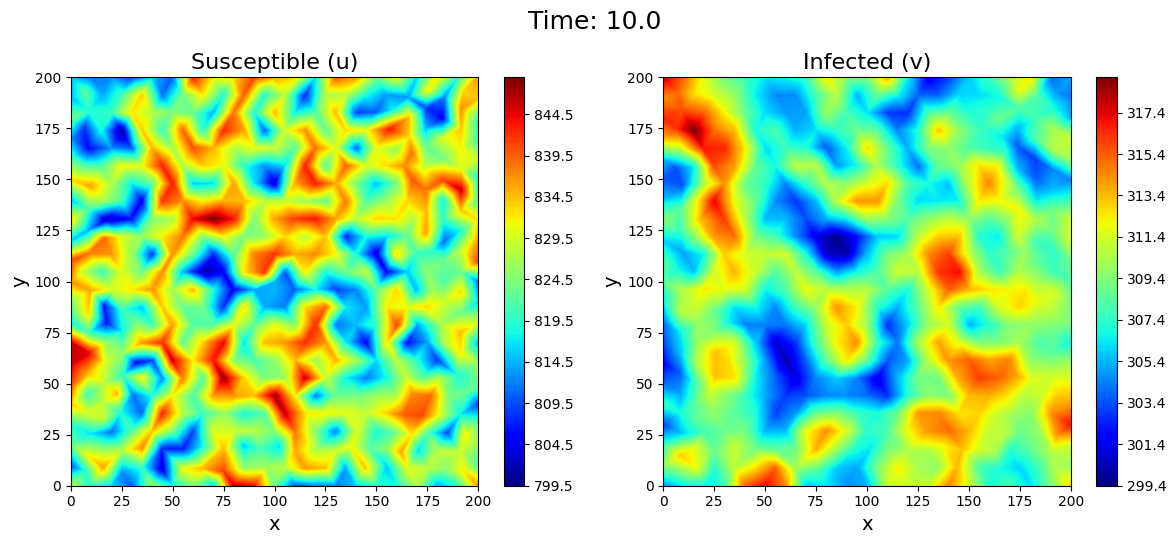

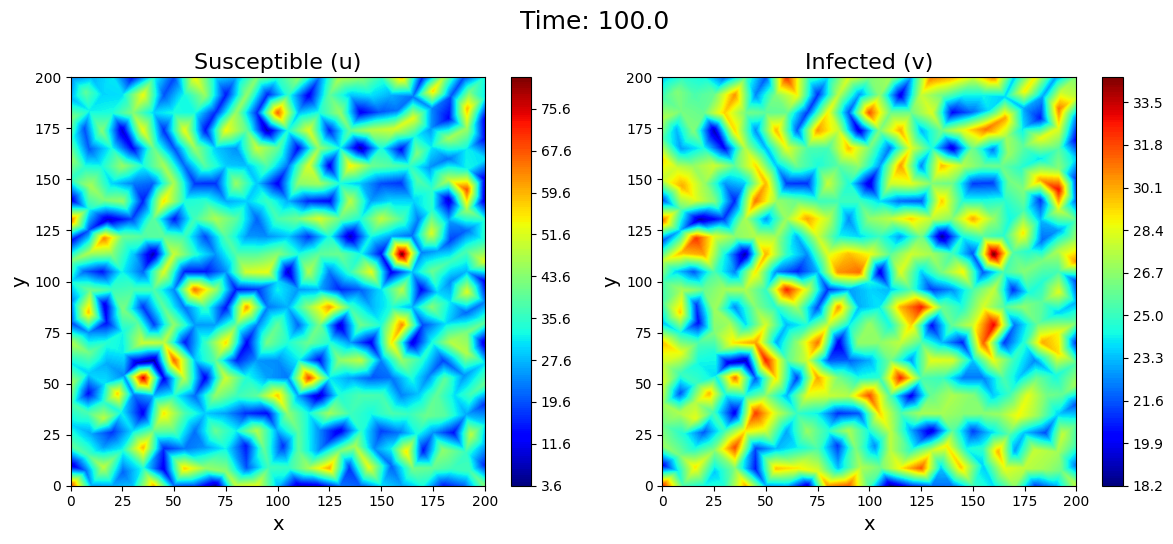

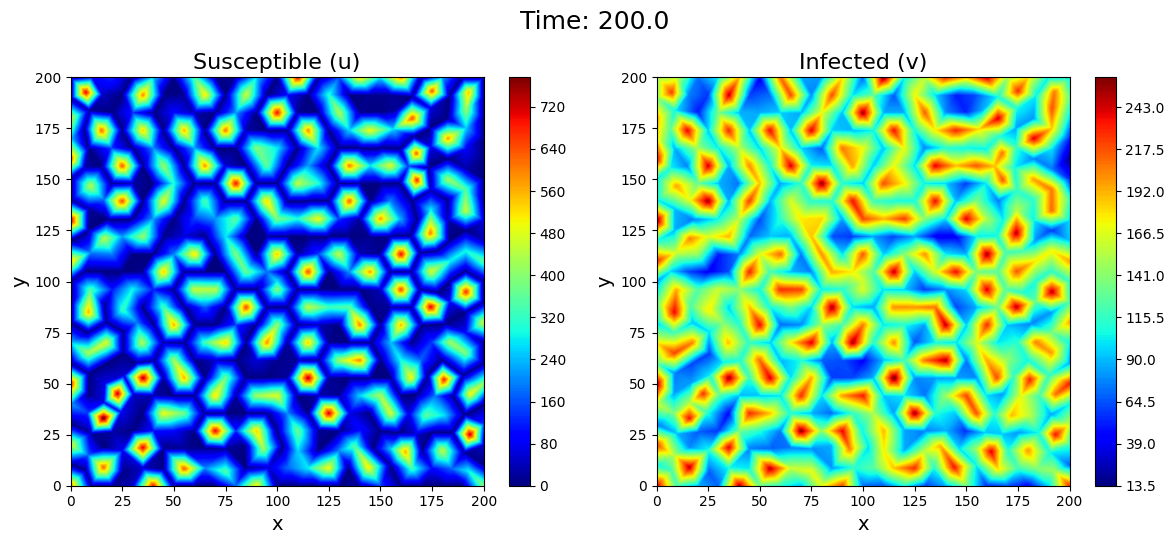

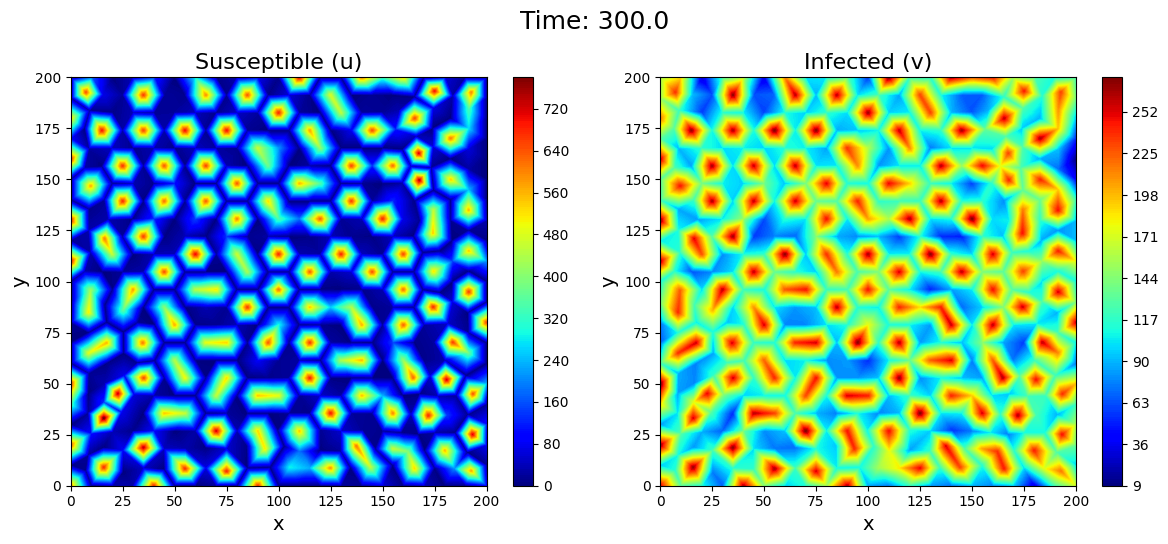

In [34]:
INDEX = 1/dt * TIME
INDEX = INDEX.astype(int)

for IND in INDEX:
    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

    # Plot u0 on the first subplot (left)
    contour1 = ax1.tricontourf(x, y, u_values[IND].flatten(), levels=200, cmap='jet')
    ax1.set_xlabel('x', fontsize=14)
    ax1.set_ylabel('y', fontsize=14)
    ax1.set_title('Susceptible (u)', fontsize=16)
    fig.colorbar(contour1, ax=ax1)

    # Plot v0 on the second subplot (right)
    contour2 = ax2.tricontourf(x, y, v_values[IND].flatten(), levels=200, cmap='jet')
    ax2.set_xlabel('x', fontsize=14)
    ax2.set_ylabel('y', fontsize=14)
    ax2.set_title('Infected (v)', fontsize=16)
    fig.colorbar(contour2, ax=ax2)

    fig.suptitle(f'Time: {dt*IND}', fontsize=18)

    plt.tight_layout()
    plt.savefig(f'plots/time_{dt*IND}_{euler}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


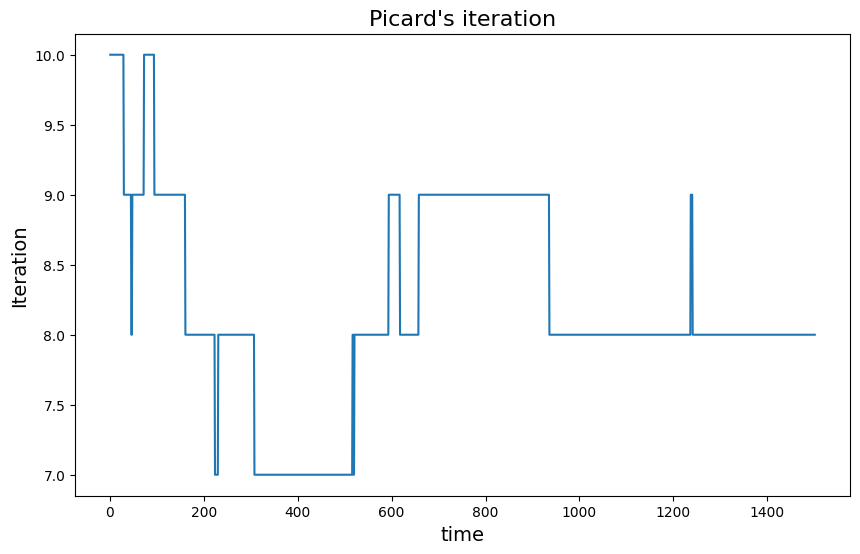

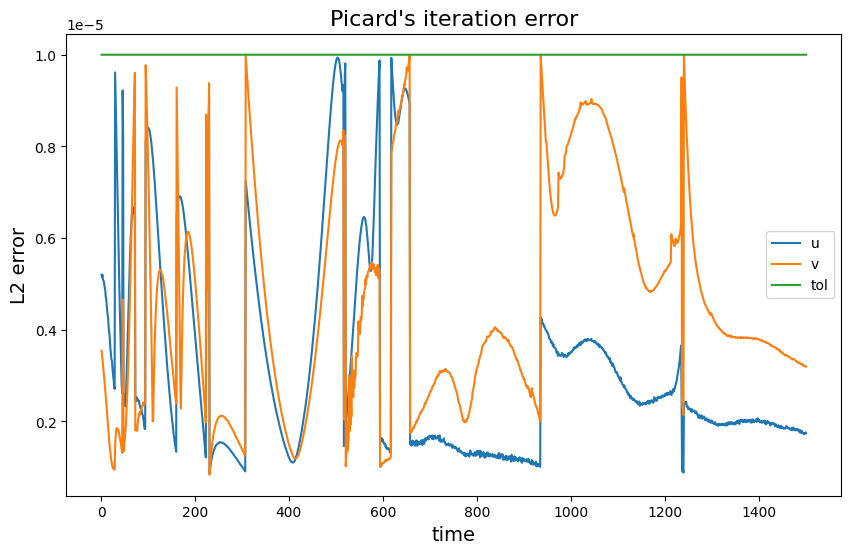

In [35]:
if(euler == 'Backward'):
    fig = plt.figure(figsize=(10,6))
    plt.plot(np.arange(int(len(u_values)))[1:], np.array(itr)[1:])
    plt.xlabel('time', fontsize=14)
    plt.ylabel('Iteration', fontsize=14)
    plt.title('Picard\'s iteration', fontsize=16)
    plt.savefig('plots/itr.eps', format='eps')

    fig = plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(u_values))[1:], u_errors[1:], label='u')
    plt.plot(np.arange(len(u_values))[1:], v_errors[1:], label='v')
    plt.plot(np.arange(len(u_values))[1:], tolerance*np.ones_like(v_errors)[1:], label='tol')
    plt.xlabel('time', fontsize=14)
    plt.ylabel(f'{error} error', fontsize=14)
    plt.title('Picard\'s iteration error', fontsize=16)
    plt.legend()
    plt.savefig('plots/error.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


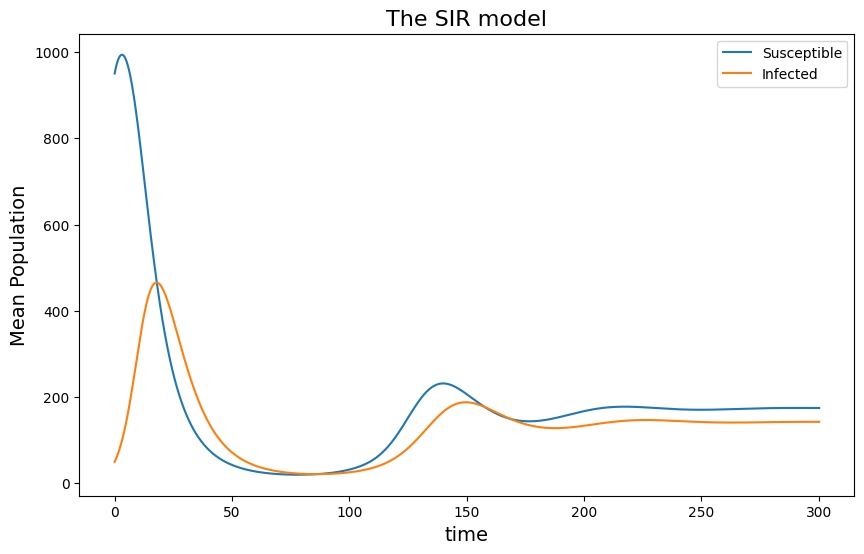

In [36]:
fig = plt.figure(figsize=(10,6))
plt.plot(dt*np.arange(len(u_values)), np.mean(u_values, axis=1), label='Susceptible')
plt.plot(dt*np.arange(len(v_values)), np.mean(v_values, axis=1), label='Infected')
plt.xlabel('time', fontsize=14)
plt.ylabel('Mean Population', fontsize=14)
plt.title('The SIR model', fontsize=16)
plt.legend()
plt.savefig('plots/sir_mean.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


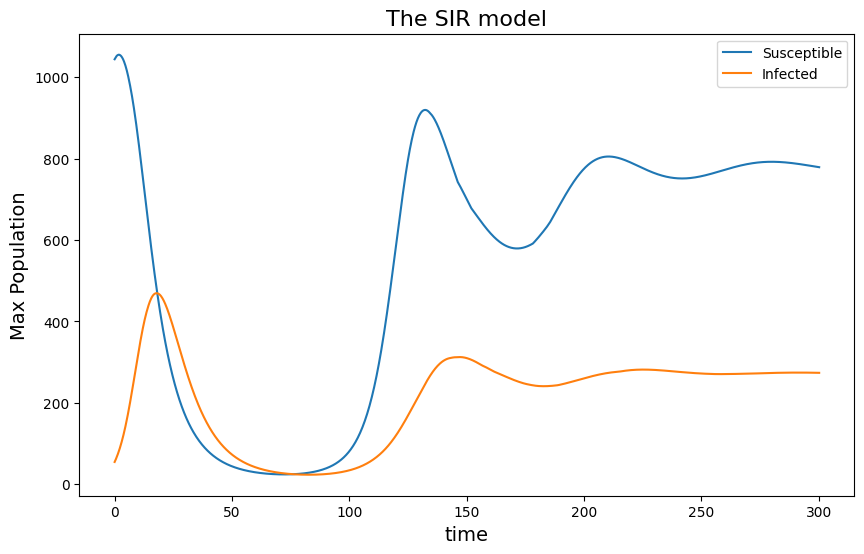

In [37]:
fig = plt.figure(figsize=(10,6))
plt.plot(dt*np.arange(len(u_values)), np.max(u_values, axis=1), label='Susceptible')
plt.plot(dt*np.arange(len(v_values)), np.max(v_values, axis=1), label='Infected')
plt.xlabel('time', fontsize=14)
plt.ylabel('Max Population', fontsize=14)
plt.title('The SIR model', fontsize=16)
plt.legend()
plt.savefig('plots/sir_max.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


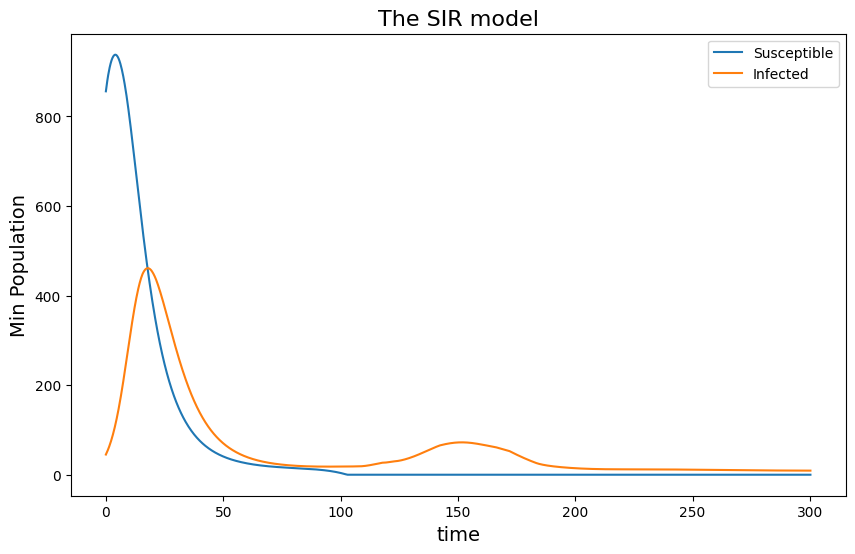

In [38]:
fig = plt.figure(figsize=(10,6))
plt.plot(dt*np.arange(len(u_values)), np.min(u_values, axis=1), label='Susceptible')
plt.plot(dt*np.arange(len(v_values)), np.min(v_values, axis=1), label='Infected')
plt.xlabel('time', fontsize=14)
plt.ylabel('Min Population', fontsize=14)
plt.title('The SIR model', fontsize=16)
plt.legend()
plt.savefig('plots/sir_min.eps', format='eps')